# Convolutional Variational AutoEncoder (VAE)

After you finish, go to File -> Download -> Download '.ipynb', save the notebook and submit to GradeScope. 

*   Gradescope: https://www.gradescope.com/courses/351582
*   Course entry code: 5V3YRX

Do not close the cell outputs after running the code cells, so that all logging and plots will be saved in the notebook for grading.

## Enable GPU settings
Go to Edit -> Notebook Settings -> Select "GPU" under Hardware Accelerator

## Imports

In [18]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_datasets as tfds

# Part 1: MNIST VAE

## Load the MNIST dataset

Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We normailze the pixel values of each image to be in range of 0-1.

In [19]:
MNIST_IMG_HEIGHT = 28
MNIST_IMG_WIDTH = 28
MNIST_IMG_CHANNEL = 1

# Images and labels are loaded as numpy arrays 
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### Preprocess data

In [20]:
# TODO: Write a function that preprocesses the data 
def preprocess_images(images: np.ndarray, img_shape = [28, 28, 1]) -> np.ndarray:
    # TODO: Reshape the input images to [N, 28, 28, 1], N is the total number of images
    #       and normalize the pixel values of each image to be in range 0-1. 
    #       Make sure the data type of images is 'float32'
    images = images.reshape([images.shape[0]] + img_shape) / 255
    
    return images.astype('float32')

train_images = preprocess_images(train_images, img_shape=[MNIST_IMG_HEIGHT, MNIST_IMG_WIDTH, MNIST_IMG_CHANNEL])
test_images = preprocess_images(test_images, img_shape=[MNIST_IMG_HEIGHT, MNIST_IMG_WIDTH, MNIST_IMG_CHANNEL])

### Visualize data

**(1pt) Q1**: Show one image for each class from the MNIST training dataset

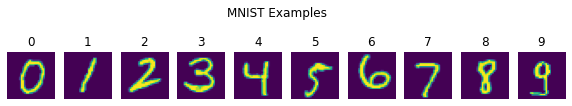

In [21]:
from IPython.core.pylabtools import figsize
import matplotlib
# TODO: Write a function that shows one image for each class 
def display_classes(x,y, class_dict = None, cmap = 'gray', title = 'Examples of Classes') -> matplotlib.figure.Figure:
    categories = np.unique(y)
    fig, axes = plt.subplots(1, categories.shape[0], figsize=(10, 2))
    fig.suptitle(title)

    for i, category in enumerate(categories):
        img = x[y == category]
        random_index = np.random.choice(img.shape[0], size=1, replace=False)
        axes[i].imshow(np.squeeze(img[random_index]))
        axes[i].title.set_text(category)
        axes[i].axis('off')

    return fig

# Call
MNIST_fig = display_classes(train_images, train_labels, title = 'MNIST Examples')
MNIST_fig.show()

We can use tf.data to create training batch and shuffle the data.

In [22]:
train_size = 60000
test_size = 10000
batch_size = 32

# The given tensors (numpy arrays) are sliced along their first dimension.
# Then consecutive elements of the shuffled dataset are combined into batches. 
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

The following code is NOT part of the VAE implementation, but to illustrate how to convert the dataset into a python list, which is easier for us to understand its structure.

In [23]:
# The train_dataset and test_dataset are tensorflow object called BatchDataset.
# It is a generator. We can iterate over it to see what's in there:
for train_batch in train_dataset:
    print(train_batch.shape)
    break 
# Or, we can convert it back to a list of batches of numpy arrays using the following method:
train_dataset_list = list(train_dataset.as_numpy_iterator())
print(len(train_dataset_list)) # 1875 * 32 = 60000
print(train_dataset_list[0].shape)

(32, 28, 28, 1)
1875
(32, 28, 28, 1)


## Define VAE Model

In this VAE example, we use two small Convolutional networks for the encoder and decoder networks. We create a CVAE model by subclassing the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class. We also use the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to simplify the implementation (so that we don't need to write the *call* function.)

**(2pt) Q2**: Complete the code for defining the decoder net below. What is the input shape to the first convolution transpose layer in the decoder? Explain how you decided this input shape. Show the calculation in terms of the `img_size`, `num_convolutions`, and `strides` used in the deconv layers.

> The input shape for the encoder is (28, 28, 1), which is the size of the input image (with 1 channel).



**(2pt) Q3**: What is the last layer of the decoder net? Explain how you decided the number of filters for this layer.

> The last layer of the decoder net is a 2D convolution transpose layer without an activation function. The number of filters I choose for the final layer is 1, since only 1 image (28, 28, 1) is desired as the output for the decoder.



In [51]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, num_convolutions = 2, img_size = 28, channels = 1):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        m = int(img_size * 2 ** (-num_convolutions)) # size of images after convolution

        """ The encoder net is defined below.
        Note, it's common practice to avoid using batch normalization when training VAEs,
        since the additional stochasticity due to using mini-batches may aggravate
        instability on top of the stochasticity from sampling.
        """
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(input_shape=(img_size, img_size, channels)))
        # Conv layers
        for n_conv in range(num_convolutions):
            self.encoder.add(tf.keras.layers.Conv2D(filters=32*2**n_conv, kernel_size=3, strides=(2, 2), activation='relu'))
        self.encoder.add(tf.keras.layers.Flatten())
        # No activation
        self.encoder.add(tf.keras.layers.Dense(latent_dim + latent_dim)) # one latent_dim for the mean, and the other latent_dim for the logarithmic variance

        # TODO: Define the decoder layers below by mirroring the architecture of the above encoder net. 
        #       Specifically use a fully-connected layer followed by three convolution transpose layers 
        #       (a.k.a. deconvolutional layers in some contexts).

        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.layers.InputLayer(input_shape=(latent_dim, )))
        self.decoder.add(tf.keras.layers.Dense(units=int(img_size/2**num_convolutions)*int(img_size/2**num_convolutions)*32, activation=tf.nn.relu))
        self.decoder.add(tf.keras.layers.Reshape(target_shape=(int(img_size/2**num_convolutions), int(img_size/2**num_convolutions), 32)))
        for n_conv in reversed(range(num_convolutions)):
            self.decoder.add(tf.keras.layers.Conv2DTranspose(filters=32*2**n_conv, kernel_size=3, strides=2, padding='same', activation='relu'))
        # No activation used in the last layer because we are using tf.nn.sigmoid_cross_entropy_with_logits for reconstruction loss
        # This means we need logits as output, not 'probablities' after sigmoid.
        self.decoder.add(tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=3, strides=1, padding='same'))

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
            
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        """The encode function split the output of encoder dense layer into two
        sets each with latent_dim. One is used as the mean, and the other is 
        logvar. 
        """
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)

        return mean, logvar

    def reparameterize(self, mean, logvar):
        """ Review the reparameterization trick to understand the formula below."""
        eps = tf.random.normal(shape=mean.shape)

        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)

        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

## Define Loss Function and Optimizer

### Optimizer

In [25]:
optimizer = tf.keras.optimizers.Adam(1e-4) # we set the learning rate to a small number for higher stability during training. 

### Loss function
VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$. 

Thus, our *loss function* is to minimize the negation of the above equation:

$$Loss = - (\log p(x| z) + \log p(z) - \log q(z|x)) $$

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

**(2pt) Q4**: Read the function definition of `log_normal_pdf` below. We know the probablity density function (PDF) of a normal distribution is:



> $$f(x_i; μ, σ^2) = \frac{1}{σ\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-μ}{σ})^2} $$

where $μ$ is mean, and $σ$ is standarad deviation. If we take log of the above equation, we get the log PDF of the normal distribution:


> $$ log(f(x_i; μ, σ^2)) = -\ln{σ} - \frac{1}{2}\ln{(2\pi)} - \frac{1}{2}(\frac{x-μ}{σ})^2 $$

Note that `log_normal_pdf` is given a sample $x$, the mean $\mu$, and the log variance $logvar$ of the distribution. Please derive the formula in `tf.reduce_sum()` in `log_normal_pdf`'s function return. (Hint: variance is the square of $σ$ )

> $$ f(x_i; μ, σ^2) = \frac{1}{σ\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-μ}{σ})^2} $$

> $$ → ln(f(x_i; μ, σ^2)) = \ln{(\frac{1}{σ\sqrt{2\pi}})} + \ln{(e^{-\frac{1}{2}(\frac{x-μ}{σ})^2})} = -\ln{(σ\sqrt{2π})} - \frac{1}{2}(\frac{x-μ}{σ})^2 $$

> $$ = -\ln{σ} - \frac{1}{2}\ln{2π}-\frac{1}{2}(x-μ)^2σ^{-2} = -\frac{1}{2}((x-μ)^2σ^{-2} + 2\ln{σ}+\ln{2π}) $$

> $$ = -\frac{1}{2}((x-μ)^2\ln{e^{σ^{-2}}} + \ln{σ^2} + \ln{2π}) (Q.E.D.) $$











In [26]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), # <------ Derive this formula yourself
        axis=raxis)

**(2pt) Q5**: As described in [this blog](https://www.tensorflow.org/tutorials/generative/cvae), to generate a sample  for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation, i.e, $\tilde{z}\sim{q(z|x)}$.  However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node. 
Refer to `reparameterize` function in `CVAE` class. Explain what is the *Reparametrization Trick* and how it enables the backpropagation.

> Since the latent variable $\tilde{z}\sim{q(z|x)}$ is normally distributed, we can approximate it with another normal distribution. In this case, we approximate $z$ with the normally distributed $ϵ$: $$\tilde{z}=μ+σϵ$$ where $ϵ \sim N(0, 1)$, $μ$ and $σ$ represent the mean and standard deviation of Gaussian distribution respectively.

> The latent variable $\tilde{z}$ is now generated by a function of $μ$, $σ$, and $ϵ$. Since the mean and the variance come from the encoder network, it will then allow the model to backpropagate gradients in the encoder through them, while sustaining stochasticity via $ϵ$. 





**(2pt) Q6**: Recall from class that VAE has two optimization objectives: 

1.   Maximize the log likelihood $\log{p(x| z)}$, or minimize the reconstruction error.
2.   Minimize the KL divergence of the approximate from the true posterior: $D_{KL}(\log q(z|x) || \log p(z))$.

Describe which part of the loss function describes objective 1 and which part describes (an estimation of) objective 2？

Hint: We can use Monte Carlo to estimate the KL divergence of continuous distributions when there's enough data for sampling, i.e, N is large:
$$ D_{KL}(\log q(z|x) || \log p(z)) \approx \frac{1}{N}\sum_{i}^{N}\log(\frac{q(z|x)}{p(z)}) $$

> $$ Loss(x) = l_{recon}(f(x), x) + ∑l_{KL}(q(z|x) = N(μ_i, σ_i), N(0, 1)) $$

> The first term of the loss function for VAE is the reconstruction loss, which can be used to describe objective 1 of this question. This term stimulates the decoder network to learn to reconstruct data. A poor reconstruction result will lead to a large cost, which means the decoder parameterizes a likelihood distribution that does not place much "probability mass" on the true data. Therefore, the goal is to minimize the reconstruction error as much as possible.

> The second term of the loss function is a regularizer that provides the value of KL divergence between the encoder's distribution $q(z|x)$ and $p(z)$. The purpose of this regularizer means to keep the encoder outputs $z$ (the digit categories from 0 to 9 of the MNIST dataset in this case) as sufficiently diverse as possible. This has the effect of keeping similar representations close together, that is, minimizing the KL divergence of the apporximate from the true posterior.





In [27]:
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # calculating the reconstruction difference
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar) # calculating the KL divergence
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

### Train step

**Warning about using tf.function**: 
We can create and run a graph in TensorFlow by using tf.function as a decorator.
Graphs let our TensorFlow run fast and run in parallel. Thus, using it can speed up training significantly. 
However when you see the following error:


> *ValueError: tf.function-decorated function tried to create variables on non-first call'*


A quick walk-around of this is to **re-run the function definition that is decorated by tf.function**, for example, the one below. By doing this, we force the Graph to reset its variable and thus clears the error. 

In [52]:
@tf.function
def train_step(model, x, optimizer):
    # Executes one training step and returns the loss.
    # This function computes the loss and gradients, and uses the latter to
    # update the model's parameters.

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

Note that the training takes ~6 sec for each epoch. 

### Helper functions

**(1pt) Q7**: Complete below function. Note that we use `CVAE`'s `sample` function to obtain the decoded images from latent space. Explain why we set `apply_sigmoid == True` when decoding. (Hint: Think of why we need to apply sigmoid on the decoder's outputs.)

In [29]:
# TODO: Write a function that encodes the test_images to latent codes,
#       and decodes the reconstructed images from the latent codes 
#       at a certain epoch during training. 
def generate_and_display_images(model, epoch, test_images, cmap = None) -> None:
    mean, logvar = model.encode(test_images)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    plt.title('image_at_epoch_{:04d}'.format(epoch))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1);
        plt.imshow(predictions[i, :, :, 0], cmap)
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [30]:
# TODO: Write the training iterations.
# Train the cvae model by calling the train_step defined above 
# Test by calculating the loss on the test data after each training epoch.
# Generate the reconstructed image using the test set and log the loss for each epoch. 
# Return the trained model
def main_train_loop(model, optimizer, train_dataset, test_dataset, test_sample, cmap = None, epochs = 10) -> tf.keras.Model:
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_data in train_dataset:
            train_step(model, train_data, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_data in test_dataset:
            loss(compute_loss(model, test_data))
        elbo = loss.result()
        
        #display.clear_output()
        print('Epoch: {}, Test set ELBO: {},\ntime spent:{}'.format(epoch, elbo, end_time - start_time))
        generate_and_display_images(model, epoch, test_images=test_sample, cmap=cmap)
    
    return model

### Main

In [31]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16 # number of examples to generate visualize the training progress

# Instantiate the model
mnist_model = CVAE(latent_dim=latent_dim, num_convolutions=2, img_size=MNIST_IMG_HEIGHT, channels=MNIST_IMG_CHANNEL)

# Create a batch of random vector for generating sampled images. 
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1): # 'take' creates a Dataset with at most count elements from this dataset.
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

**(2 pts) Q8**: Plot the encoder and decoder architecture as a flow chart diagram with shape specifications. Are the input and output shapes match your design?

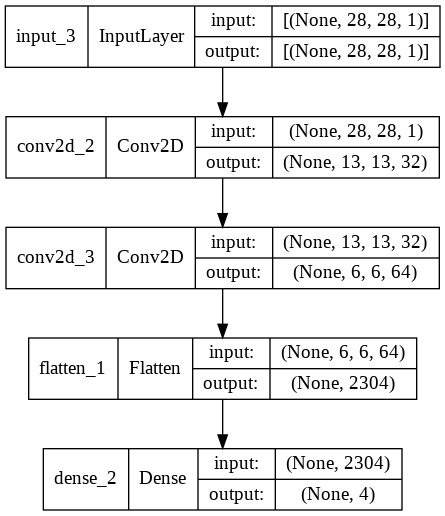

In [32]:
tf.keras.utils.plot_model(mnist_model.encoder, show_shapes=True)

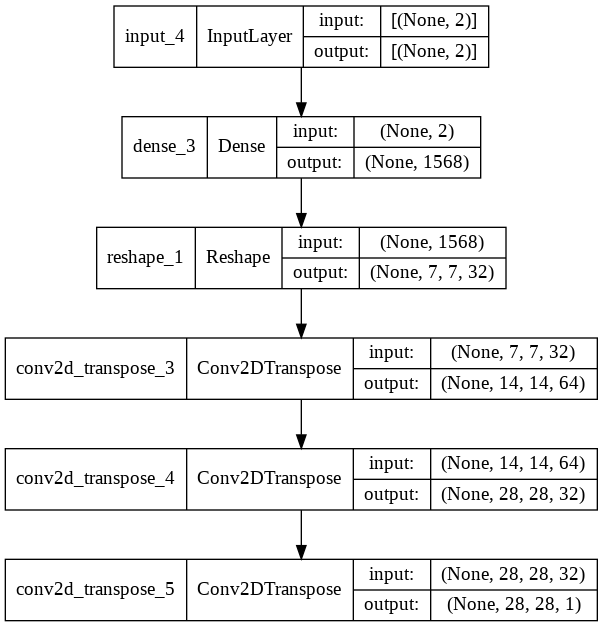

In [33]:
tf.keras.utils.plot_model(mnist_model.decoder, show_shapes=True)

**(3 pts) Q9**: Call the completed `main_train_loop` function. Show the following in the output console when training:

1.   Time used for each epoch training
2.   ELBO value (the negation of the loss value) on the test dataset for each epoch
3.   The reconstructed images of the sampled test data (use function `generate_and_display_images`).

Epoch: 1, Test set ELBO: 182.99740600585938,
time spent:84.15690922737122


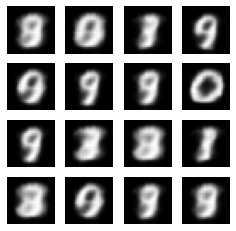

Epoch: 2, Test set ELBO: 174.28648376464844,
time spent:75.38437914848328


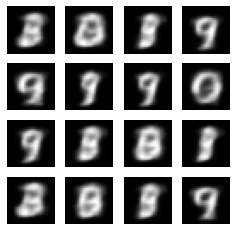

Epoch: 3, Test set ELBO: 170.29147338867188,
time spent:75.61272025108337


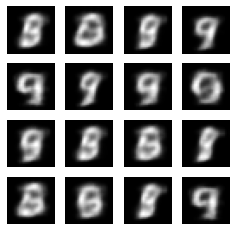

Epoch: 4, Test set ELBO: 167.43431091308594,
time spent:76.8227424621582


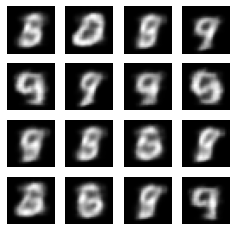

Epoch: 5, Test set ELBO: 165.27420043945312,
time spent:76.72461819648743


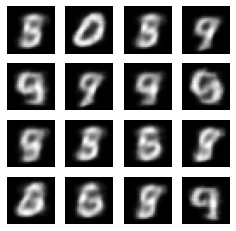

Epoch: 6, Test set ELBO: 163.46435546875,
time spent:76.00124883651733


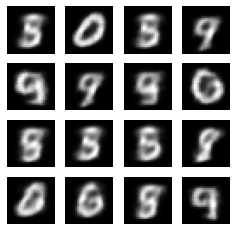

Epoch: 7, Test set ELBO: 162.21107482910156,
time spent:76.07876563072205


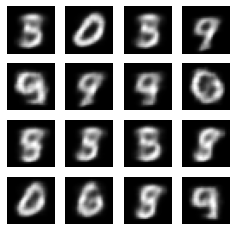

Epoch: 8, Test set ELBO: 161.14181518554688,
time spent:77.03173851966858


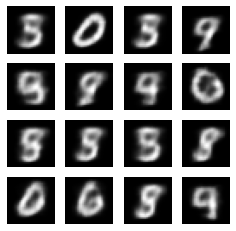

Epoch: 9, Test set ELBO: 160.40362548828125,
time spent:76.01350402832031


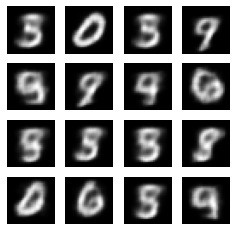

Epoch: 10, Test set ELBO: 159.56541442871094,
time spent:76.43453931808472


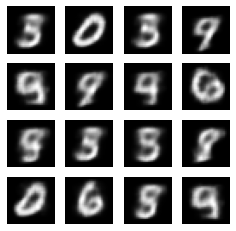

Epoch: 11, Test set ELBO: 159.5386199951172,
time spent:76.20908498764038


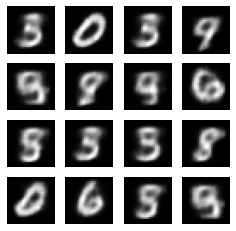

Epoch: 12, Test set ELBO: 158.81370544433594,
time spent:77.1704409122467


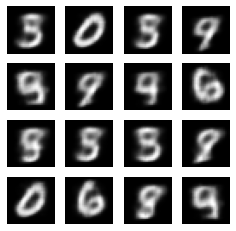

Epoch: 13, Test set ELBO: 158.5018768310547,
time spent:76.65086460113525


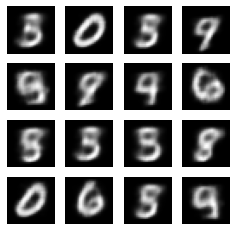

Epoch: 14, Test set ELBO: 157.9060821533203,
time spent:76.89726376533508


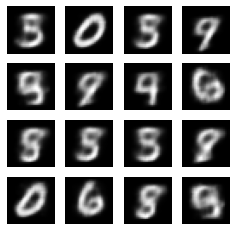

Epoch: 15, Test set ELBO: 157.4175567626953,
time spent:76.03624868392944


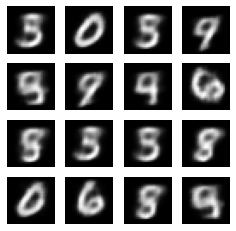

Epoch: 16, Test set ELBO: 157.7454833984375,
time spent:76.29931306838989


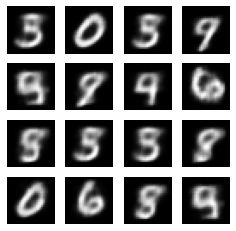

Epoch: 17, Test set ELBO: 157.32699584960938,
time spent:76.17427611351013


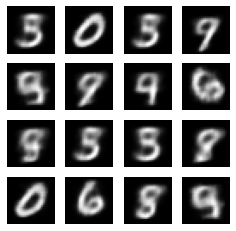

Epoch: 18, Test set ELBO: 156.9130401611328,
time spent:76.8316638469696


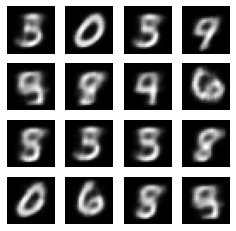

Epoch: 19, Test set ELBO: 157.21047973632812,
time spent:77.8488039970398


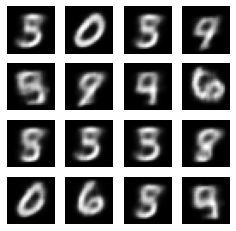

Epoch: 20, Test set ELBO: 156.79757690429688,
time spent:76.99862551689148


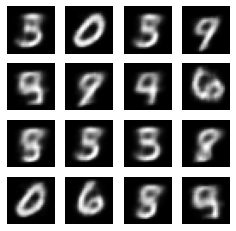

In [34]:
# Let's call the main train loop
mnist_vae = main_train_loop(mnist_model, optimizer, train_dataset, test_dataset, test_sample, cmap = 'gray', epochs = 20)

## Results

### Visualize the latent space

**(2pt) Q10**: Complete the function below. Visualize the latent space. Is there a clear boundary between the classes?

> The boundaries of different classes are overlapped with one another.



In [35]:
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px # For better plot

# TODO: Write a function that encodes the input images to latent codes
def get_allClass_encodings(model: tf.keras.Model, inputs: np.ndarray) -> np.ndarray:
    mean, logvar = model.encode(inputs)
    z = model.reparameterize(mean, logvar)

    return z

# TODO: Write a function that visualize the distribution of latent codes on a 2D scatter plot.
# Note, if you use higher latent_dims > 2, you need to first project the high dimensional vector to
# 2D space and then visualize. 
# For dimension reduction, you can use PCA.
def plot_latent_space(latent_vectors, labels, project_method = None ) -> matplotlib.figure.Figure:
    pca = PCA(n_components=2) # number of components to keep
    reshape = pca.fit_transform(latent_vectors)

    df = pd.DataFrame(reshape, columns=['x', 'y'])
    df['labels'] = labels
    fig = px.scatter(df, x='x', y='y', color='labels', category_orders={'labels': np.unique(labels)})

    return fig

all_encodings = get_allClass_encodings(mnist_model, test_images)
print(all_encodings.shape)
mnist_scatter = plot_latent_space(all_encodings, test_labels, project_method = 'PCA')
mnist_scatter.show()

(10000, 2)


### Walk (Interpolate) between two digit classes

**(2pt) Q11**: Complete the function below. Show the morphing process of 'walking' from one class to another.

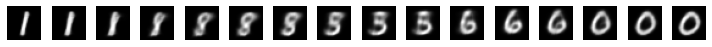

In [36]:
# TODO: Write a function that walks from one digit class to another. Show the
# interpolated digit image along the walk in the latent space.
def walk_src_to_dst(model, x, y, src, tgt, n_steps = 16) -> matplotlib.figure.Figure:
    # (1) Get the latent encoding of all images first
    latent_encoding = get_allClass_encodings(model, x)
    # (2) Compute the mean latent code of all digits from the src (source) class,
    #     and the mean latent code of all digits from the tgt (target) class
    df = pd.DataFrame(latent_encoding.numpy())
    df[df.shape[1]] = y
    df_src = df[df[df.shape[1] - 1] == src]
    df_tgt = df[df[df.shape[1] - 1] == tgt]
    mean_src = df_src[df_src.columns[:df_src.shape[1] - 1]].mean(axis=0)
    mean_tgt = df_tgt[df_tgt.columns[:df_tgt.shape[1] - 1]].mean(axis=0)
    # (3) Compute evenly spaced latent vectors with np.linespace
    #     The starting value should be the mean latent code of the src class,
    #     The ending value should be the mean latent code of the tgt class. 
    #     Number of samples to generate is the total number of steps in the walk. 
    latent_space_walk = np.linspace(mean_src, mean_tgt, num=n_steps)
    # (4) Plot
    fig, axes = plt.subplots(1, latent_space_walk.shape[0], figsize=(10, 2))

    for i in range(latent_space_walk.shape[0]):
        decode = model.decode(tf.expand_dims(latent_space_walk[i], axis=0), apply_sigmoid=True)
        axes[i].imshow(decode[0, :, :, 0], cmap='gray')
        axes[i].axis('off')
    
    plt.tight_layout()
    
    return fig
    

walk_fig = walk_src_to_dst(mnist_vae, train_images, train_labels, 1, 0)
walk_fig.show()

# Part 2: CIFAR-10 VAE
**(8 pts) Q1**: Repeat the above flow on CIFAR-10 data set. Try to reuse functions already defined. 

## Load the CIFAR-10 dataset

In [37]:
CIFAR_IMG_HEIGHT = 32
CIFAR_IMG_WIDTH = 32
CIFAR_IMG_CHANNEL = 3

CIFAR_CLASS_DICT = {0: 'airplane', 1: 'automobile', 2: 'bird',  3: 'cat',  4: 'deer', 
                    5: 'dog',      6: 'frog',       7: 'horse', 8: 'ship', 9: 'truck'}
                    
(cifar_img_train, cifar_label_train), (cifar_img_test, cifar_label_test) = tf.keras.datasets.cifar10.load_data()
print(cifar_img_train.shape, cifar_label_train.shape, cifar_img_test.shape, cifar_label_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### Preprocess data
You can modify the `preprocess_images` function in Part 1 to be re-used here.

In [38]:
# Remove the extra dimension of the CIFAR labels 
cifar_label_train = np.squeeze(cifar_label_train)
cifar_label_test = np.squeeze(cifar_label_test)

cifar_img_train = preprocess_images(cifar_img_train, img_shape= [CIFAR_IMG_HEIGHT, CIFAR_IMG_WIDTH, CIFAR_IMG_CHANNEL])
cifar_img_test = preprocess_images(cifar_img_test, img_shape= [CIFAR_IMG_HEIGHT, CIFAR_IMG_WIDTH, CIFAR_IMG_CHANNEL])

### Visualize data
You can modify the display_classes funciton in Part 1 to be re-used here

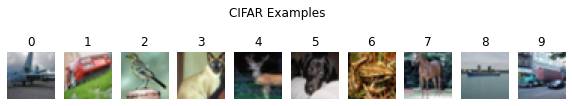

In [39]:
CIFAR_fig = display_classes(cifar_img_train, cifar_label_train, class_dict = CIFAR_CLASS_DICT, cmap = None, title = 'CIFAR Examples')
CIFAR_fig.show()

In [40]:
train_size = 50000
test_size = 10000
batch_size = 32

# The given tensors (numpy arrays) are sliced along their first dimension.
# Then consecutive elements of the shuffled dataset are combined into batches. 
cifar_train_dataset = (tf.data.Dataset.from_tensor_slices(cifar_img_train)
                 .shuffle(train_size).batch(batch_size))
cifar_test_dataset = (tf.data.Dataset.from_tensor_slices(cifar_img_test)
                .shuffle(test_size).batch(batch_size))

## Training
If configured approriately, we can reuse the `CVAE` class, the optimizer and the loss function above.

In [41]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 16 # number of examples to generate visualize the training progress

# Instantiate the model
cifar_model = CVAE(latent_dim, num_convolutions=3, img_size=CIFAR_IMG_HEIGHT, channels=CIFAR_IMG_CHANNEL)

# Create a batch of random vector for generating sampled images. 
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for cifar_test_batch in cifar_test_dataset.take(1): # 'take' creates a Dataset with at most count elements from this dataset.
    cifar_test_sample = cifar_test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 1, Test set ELBO: 1891.532958984375,
time spent:10.198882818222046


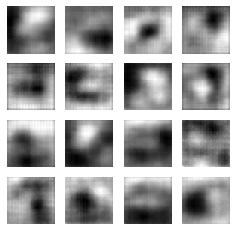

Epoch: 2, Test set ELBO: 1876.7584228515625,
time spent:8.919394254684448


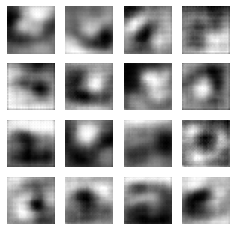

Epoch: 3, Test set ELBO: 1872.2138671875,
time spent:9.006535291671753


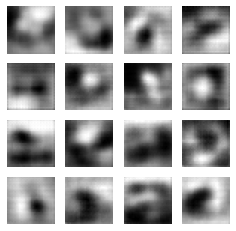

Epoch: 4, Test set ELBO: 1868.45263671875,
time spent:9.24673581123352


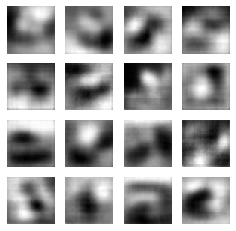

Epoch: 5, Test set ELBO: 1860.2174072265625,
time spent:8.894137382507324


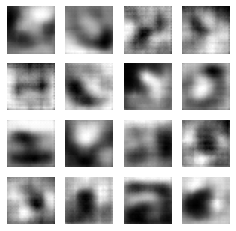

Epoch: 6, Test set ELBO: 1855.419677734375,
time spent:9.006677627563477


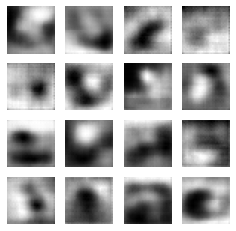

Epoch: 7, Test set ELBO: 1854.0537109375,
time spent:8.707442045211792


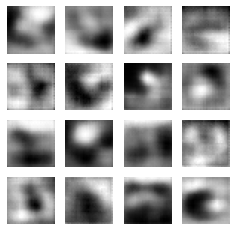

Epoch: 8, Test set ELBO: 1852.55908203125,
time spent:9.083105564117432


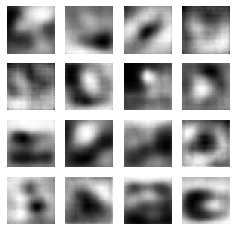

Epoch: 9, Test set ELBO: 1852.4454345703125,
time spent:9.000332355499268


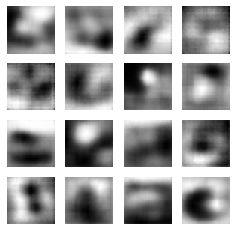

Epoch: 10, Test set ELBO: 1850.8216552734375,
time spent:9.074748277664185


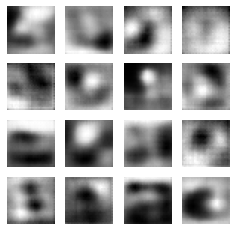

Epoch: 11, Test set ELBO: 1850.0869140625,
time spent:9.090351343154907


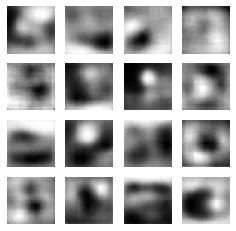

Epoch: 12, Test set ELBO: 1850.1180419921875,
time spent:8.76730489730835


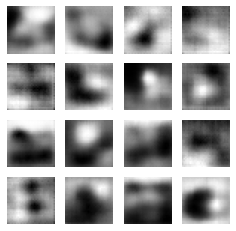

Epoch: 13, Test set ELBO: 1850.5247802734375,
time spent:8.851646900177002


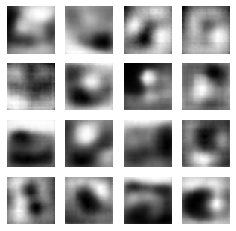

Epoch: 14, Test set ELBO: 1851.5025634765625,
time spent:8.924461603164673


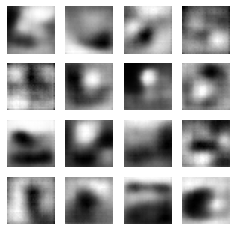

Epoch: 15, Test set ELBO: 1848.285888671875,
time spent:8.905273675918579


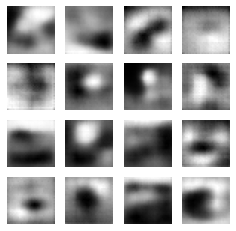

Epoch: 16, Test set ELBO: 1848.729248046875,
time spent:9.226595640182495


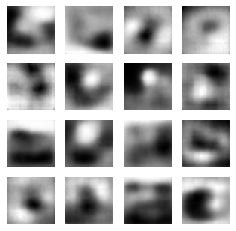

Epoch: 17, Test set ELBO: 1848.4456787109375,
time spent:8.941935300827026


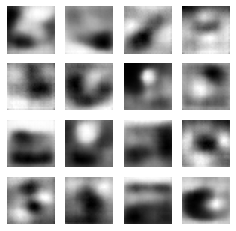

Epoch: 18, Test set ELBO: 1847.94970703125,
time spent:10.309136629104614


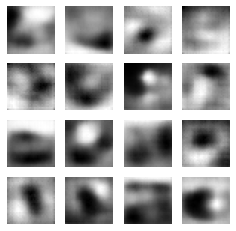

Epoch: 19, Test set ELBO: 1847.419189453125,
time spent:13.18546175956726


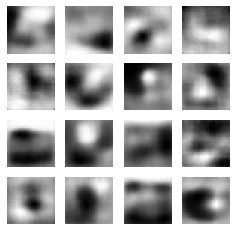

Epoch: 20, Test set ELBO: 1846.9876708984375,
time spent:8.910653352737427


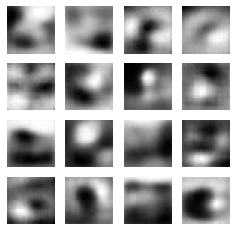

In [ ]:
# Let's call the main train loop
cifar_vae = main_train_loop(cifar_model, optimizer, cifar_train_dataset, cifar_test_dataset, cifar_test_sample, cmap='gray', epochs = 20)

## Results

### Visualize latent space

In [ ]:
cifar_all_encodings = get_allClass_encodings(cifar_vae, cifar_img_test)
print(cifar_all_encodings.shape)
cifar_scatter = plot_latent_space(cifar_all_encodings, cifar_label_test, project_method = 'PCA')
cifar_scatter.show()

(10000, 16)


### Walk (Interpolate) between two cifar classes

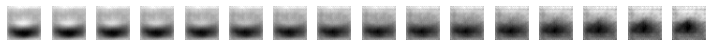

In [ ]:
cifar_walk_fig = walk_src_to_dst(cifar_vae, cifar_img_train, cifar_label_train, 1, 0)
cifar_walk_fig.show()

**(1 pt) Q2:** Were you able to generate clear images with the CIFAR-10 data set? Can you think of any ways to improve the quality of the reconstructed images?

> No. I think it's mainly due to the fact that we are applying the same CVAE model on both MNIST and CIFAR-10 while thge dataset images of CIFAR-10 has far more details in comparison with those of MNIST. This causes decoderbeing incapable of reconstructing clear images of CIFAR-10. In order to improve the reconstruction results, we can either increase the number of epochs for the training session or redesign a new CVAE encoder/decoder with more complexity.



# Grad/EC


**(4 pts) Grad Q1**: Modify `compute_loss` to use Maximum Mean Discrepancy (MMD) as described in [another blog](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/) and train a new model with the new loss function on CIFAR-10.

## MMD Loss 


In [53]:
# TODO: Use MMD to define the loss
def gaussian_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))
    #return tf.exp(-tf.reduce_mean(((x - y)**2) / (2 * logvar**2)))

def mmd(x, y):
    x_kernel = gaussian_kernel(x, x)
    y_kernel = gaussian_kernel(y, y)
    xy_kernel = gaussian_kernel(x, y)

    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

def compute_loss_mmd(model, x):
    mean, logvar = model.encode(x) #train_z
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z) #train_xr

    true_samples = tf.random.normal(tf.stack([batch_size, latent_dim]))
    loss_mmd = mmd(true_samples, z)
    loss_nll = tf.reduce_mean(tf.square(x_logit - x))

    return -tf.reduce_mean(loss_mmd + loss_nll)

@tf.function
def train_step_mmd(model, x, optimizer):
    with tf.GradientTape as tape:
        loss = compute_loss_mmd(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

In [54]:
# TODO: Modify the function to use the MMD loss function.
def main_train_loop_mmd(model, optimizer, train_dataset, test_dataset, test_sample, cmap=None, epochs = 10):
    for epoch in range(1, epochs + 1):
        for train_data in train_dataset:
            train_step(model, train_data, optimizer)
        
        loss = tf.keras.metrics.Mean()
        for test_data in test_dataset:
            loss(compute_loss_mmd(model, test_data))
        MMD = loss.result()

        print('Epoch: {}, Test set MMD: {}'.format(epoch, MMD))
        generate_and_display_images(model, epoch, test_images=test_sample, cmap=cmap)

    return model

In [55]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 16 # number of examples to generate visualize the training progress

# Instantiate the model
cifar_model_mmd = CVAE(latent_dim, num_convolutions=3, img_size=CIFAR_IMG_HEIGHT, channels=CIFAR_IMG_CHANNEL)

Epoch: 1, Test set MMD: -0.9963607788085938


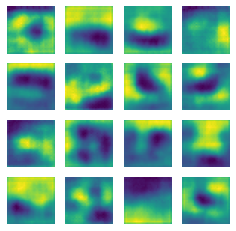

Epoch: 2, Test set MMD: -1.0968505144119263


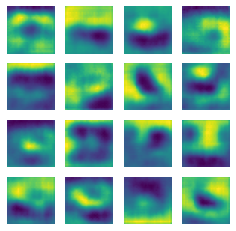

Epoch: 3, Test set MMD: -1.0578410625457764


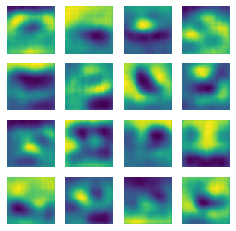

Epoch: 4, Test set MMD: -1.0654468536376953


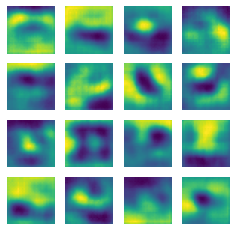

Epoch: 5, Test set MMD: -1.1150686740875244


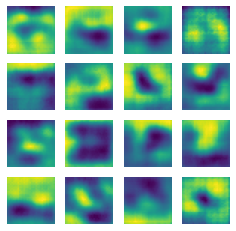

Epoch: 6, Test set MMD: -1.0614169836044312


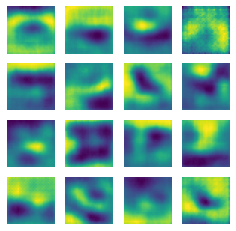

Epoch: 7, Test set MMD: -1.1074373722076416


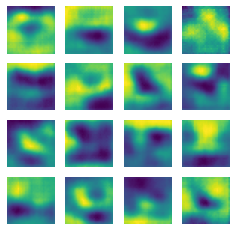

Epoch: 8, Test set MMD: -1.1090284585952759


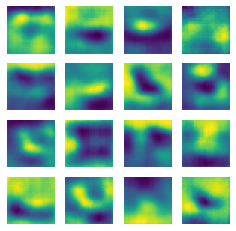

Epoch: 9, Test set MMD: -1.1123430728912354


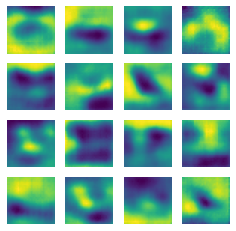

Epoch: 10, Test set MMD: -1.1755359172821045


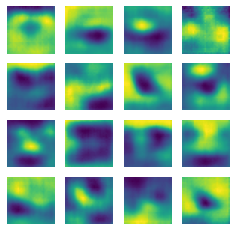

Epoch: 11, Test set MMD: -1.1445368528366089


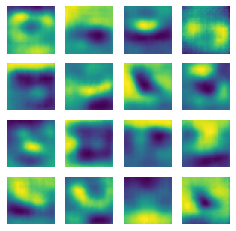

Epoch: 12, Test set MMD: -1.1832345724105835


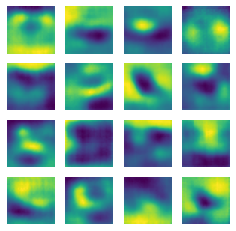

Epoch: 13, Test set MMD: -1.143490195274353


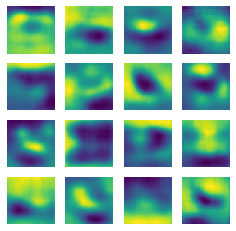

Epoch: 14, Test set MMD: -1.116489052772522


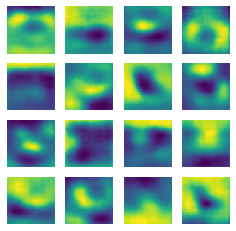

Epoch: 15, Test set MMD: -1.2010992765426636


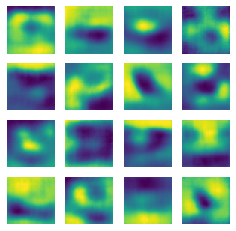

Epoch: 16, Test set MMD: -1.1980186700820923


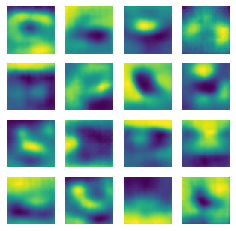

Epoch: 17, Test set MMD: -1.2124240398406982


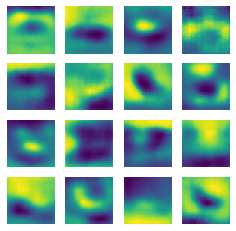

Epoch: 18, Test set MMD: -1.1933761835098267


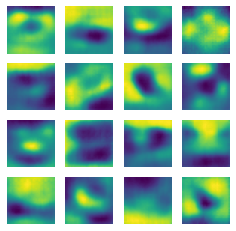

Epoch: 19, Test set MMD: -1.2021466493606567


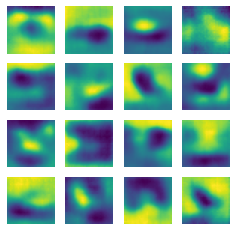

Epoch: 20, Test set MMD: -1.1809585094451904


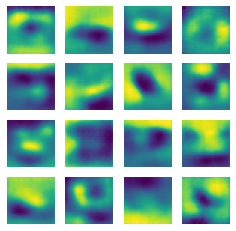

Epoch: 21, Test set MMD: -1.1984339952468872


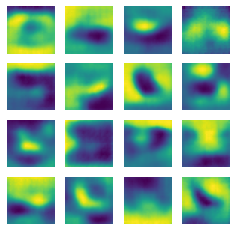

Epoch: 22, Test set MMD: -1.2114334106445312


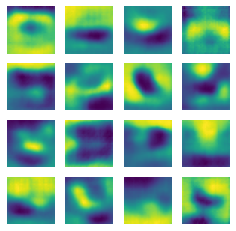

Epoch: 23, Test set MMD: -1.1562925577163696


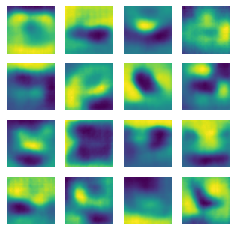

Epoch: 24, Test set MMD: -1.243668556213379


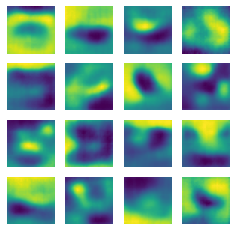

Epoch: 25, Test set MMD: -1.2143712043762207


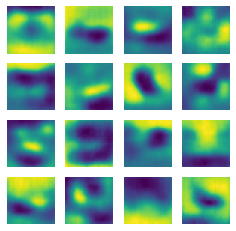

Epoch: 26, Test set MMD: -1.1357066631317139


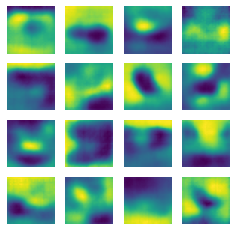

Epoch: 27, Test set MMD: -1.2160850763320923


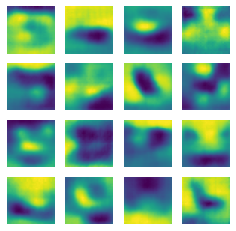

Epoch: 28, Test set MMD: -1.192811369895935


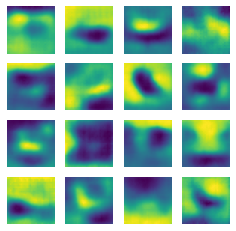

Epoch: 29, Test set MMD: -1.174942135810852


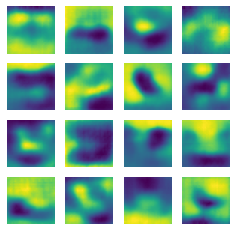

Epoch: 30, Test set MMD: -1.2138416767120361


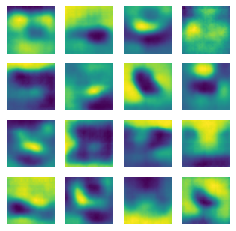

Epoch: 31, Test set MMD: -1.2011756896972656


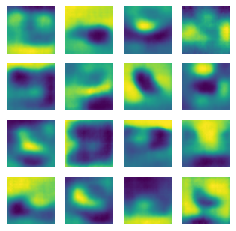

Epoch: 32, Test set MMD: -1.2364742755889893


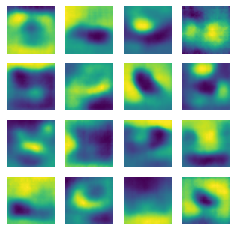

Epoch: 33, Test set MMD: -1.1724640130996704


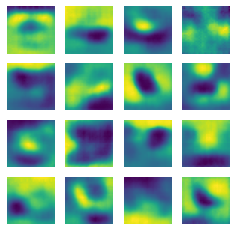

Epoch: 34, Test set MMD: -1.18329656124115


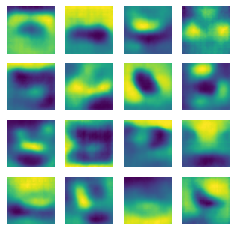

Epoch: 35, Test set MMD: -1.2052574157714844


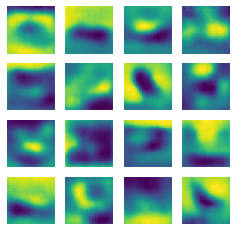

Epoch: 36, Test set MMD: -1.2090801000595093


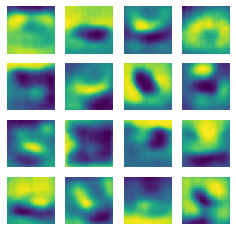

Epoch: 37, Test set MMD: -1.2302278280258179


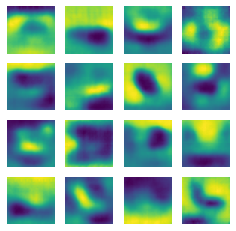

Epoch: 38, Test set MMD: -1.2187151908874512


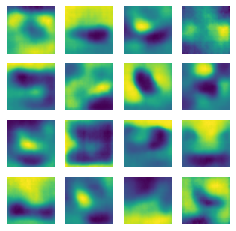

Epoch: 39, Test set MMD: -1.2584621906280518


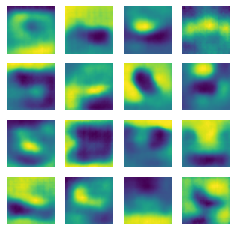

Epoch: 40, Test set MMD: -1.209991693496704


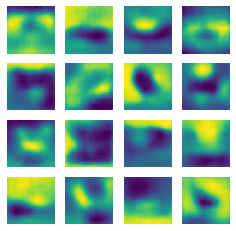

In [56]:
# Let's call the main train loop
cifar_vae_mmd = main_train_loop_mmd(cifar_model_mmd, optimizer, cifar_train_dataset, cifar_test_dataset, cifar_test_sample, epochs = 40)

## Visualize


### Visualize latent space

In [57]:
cifar_mmd_all_encodings = get_allClass_encodings(cifar_vae_mmd, cifar_img_test)
print(cifar_mmd_all_encodings.shape)
cifar_mmd_scatter = plot_latent_space(cifar_mmd_all_encodings, cifar_label_test, project_method = 'PCA')
cifar_mmd_scatter.show()

(10000, 16)


### Walk (Interpolate) between two cifar classes

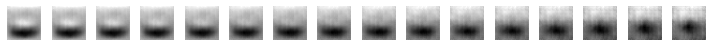

In [59]:
cifar_walk_fig = walk_src_to_dst(cifar_vae_mmd, cifar_img_train, cifar_label_train, 1, 0)
cifar_walk_fig.show()

**(5 pts) Grad Q2**: Repeat the visualization of latent space and interpolation between two classes. Did you observe any difference before and after using the MMD loss. Refer to [the blog](https://www.overleaf.com/learn/latex/Hyperlinks), Explain how MMD loss differs from the original loss function (2 pt).

> The latent space visualization after applying MMD seems more symmetric in both x-/y-axis directions, whereas the latent space visualization of ELBO is more apt to scatter along the x-axis direction. The categories in the new visualization also seem to be slightly more distinguishable.



> The KL-divergence term in the origianal loss function could be too restrictive, since it stimulates $q(z|x)$ to be a random sample of $p(z)$ for each x. This makes $q(z|x)$ uninformative about the input and the model would fail to learn any meaningful latent representation. In addition, ELBO tends to overfit the data more than MMD does. Overfitting matters when the dataset is small. Applying the MMD instead could generate albeit blurry but reasonable samples instead of clear but distorted images.

